In [14]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

dataset, info = tfds.load("fashion_mnist", split="train", with_info=True)

In [15]:
def convert(row):
    image = tf.image.convert_image_dtype(row["image"], tf.float32)
    label = tf.cast(row["label"], tf.float32)
    return image, label

In [16]:
batch_size = 32
dataset = dataset.map(convert).batch(batch_size).prefetch(1)

In [17]:
def get_generator(latent_dimension):
    
    # 조건 서브 네트워크 : 조건을 히든 표현으로 인코딩
    condition = tf.keras.layers.Input((1,))
    net = tf.keras.layers.Dense(32, activation=tf.nn.elu)(condition)
    net = tf.keras.layers.Dense(64, activation=tf.nn.elu)(net)
    
    # 히든 조건 표현을 노이즈와 업샘플에 연결
    noise = tf.keras.layers.Input(latent_dimension)
    inputs = tf.keras.layers.Concatenate()([noise, net])
    
    # Convert inputs from (batch_size, latent_dimension + 1)
    # (batch_size, latent_dimension + 1)인 inputs를
    # 컨볼루션을 사용할 수 있는 4차원 텐서로 변경
    inputs = tf.keras.layers.Reshape((1, 1, inputs.shape[-1]))(inputs)
    depth = 128
    kernel_size = 5
    
    net = tf.keras.layers.Conv2DTranspose(
        depth, kernel_size, padding="valid", strides=1, activation=tf.nn.relu
        )(inputs)  # 5x5
    net = tf.keras.layers.Conv2DTranspose(
        depth // 2, kernel_size, padding="valid", strides=2, activation=tf.nn.relu
        )(net)  # 13x13
    net = tf.keras.layers.Conv2DTranspose(
        depth // 4, kernel_size, padding="valid", strides=2, activation=tf.nn.relu, use_bias=False
        )(net)  # 29x29
    
    # 28x28x1 출력을 얻기 위해 2x2 커널과의 표준 컨볼루션
    # 이미지가 [0, 1] 범위에 있기 떄문에 출력은 sigmiod 사용
    net = tf.keras.layers.Conv2D(
        1, 2, padding="valid", strides=1, activation=tf.nn.sigmoid, use_bias=False
    )(net)
    model = tf.keras.Model(inputs=[noise, condition], outputs=net)
    return model  
    

In [18]:
def get_discriminator():
    
    # 인코더 서브네트워크: 피처 벡터를 얻는 피처 추출기
    image = tf.keras.layers.Input((28, 28, 1))
    depth = 32
    kernel_size = 3
    
    net = tf.keras.layers.Conv2D(
        depth, kernel_size, padding="same", strides=2, activation=tf.nn.relu
        )(image)  # 14x14x32
    net = tf.keras.layers.Conv2D(
        depth * 2, kernel_size, padding="same", strides=2, activation=tf.nn.relu
        )(net)  # 7x7x64
    net = tf.keras.layers.Conv2D(
        depth * 3, kernel_size, padding="same", strides=2, activation=tf.nn.relu
        )(net)  # 4x4x96
    feature_vector = tf.keras.layers.Flatten()(net)  # 4x4x96
    
    # 조건에 관한 히든 표현 만들기
    condition = tf.keras.layers.Input((1,))
    hidden = tf.keras.layers.Dense(32, activation=tf.nn.elu)(condition)
    hidden = tf.keras.layers.Dense(64, activation=tf.nn.elu)(hidden)
    
    # 피처 백터와 히든 레이블 표현 연결
    out = tf.keras.layers.Concatenate()([feature_vector, hidden])
    
    # 단일 선형 뉴런으로 이뤄진 최종 분류 레이어 추가
    out = tf.keras.layers.Dense(128, activation=tf.nn.relu)(out)
    out = tf.keras.layers.Dense(1)(out)
    
    model = tf.keras.Model(inputs=[image, condition], outputs=out)
    return model   

In [19]:
bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)


def d_loss(d_real, d_fake):
    """판별기 손실함수"""
    return bce(tf.ones_like(d_real), d_real) + bce(tf.zeros_like(d_fake), d_fake)


def g_loss(generated_output):
    """생성기 손실함수"""
    return bce(tf.ones_like(generated_output), generated_output)


In [20]:
latent_dimension = 100
G = get_generator(latent_dimension)
D = get_discriminator()

In [23]:
def train():
    # 옵티마이저 및 학습 연산을 정의한다.
    optimizer = tf.keras.optimizers.Adam(1e-5)

    @tf.function
    def train_step(image, label):
        with tf.GradientTape(persistent=True) as tape:
            noise_vector = tf.random.normal(
                mean=0, stddev=1, shape=(image.shape[0], latent_dimension)
            )
            # 생성기에서 샘플링
            fake_data = G([noise_vector, label])
            # D 손실계산
            d_fake_data = D([fake_data, label])
            d_real_data = D([image, label])

            d_loss_value = d_loss(d_real_data, d_fake_data)
            # G 손실계산
            g_loss_value = g_loss(d_fake_data)
        # 손실계산 후 그래디언트계산, 네트워크 최적화
        d_gradients = tape.gradient(d_loss_value, D.trainable_variables)
        g_gradients = tape.gradient(g_loss_value, G.trainable_variables)
        # 테이프를 영구로 정의했기 때문에 테이프 삭제
        del tape

        optimizer.apply_gradients(zip(d_gradients, D.trainable_variables))
        optimizer.apply_gradients(zip(g_gradients, G.trainable_variables))
        return g_loss_value, d_loss_value, fake_data[0], label[0]

    epochs = 10
    for epoch in range(epochs):
        for image, label in dataset:
            g_loss_value, d_loss_value, generated, condition = train_step(image, label)

        print("epoch ", epoch, "complete")
        print("loss:", g_loss_value, "d_loss: ", d_loss_value)
        print(
            "condition ",
            info.features["label"].int2str(
                tf.squeeze(tf.cast(condition, tf.int32)).numpy()
            ),
        )
        plt.imshow(tf.squeeze(generated).numpy(), cmap="gray")
        plt.show()

epoch  0 complete
loss: tf.Tensor(1.1344767, shape=(), dtype=float32) d_loss:  tf.Tensor(1.1142431, shape=(), dtype=float32)
condition  Dress


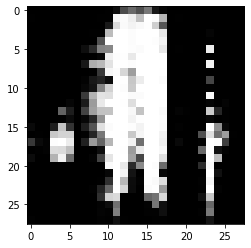

epoch  1 complete
loss: tf.Tensor(1.6713991, shape=(), dtype=float32) d_loss:  tf.Tensor(0.43483186, shape=(), dtype=float32)
condition  Dress


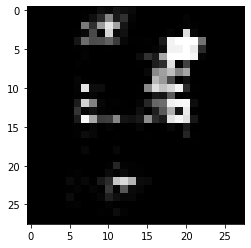

epoch  2 complete
loss: tf.Tensor(1.9752464, shape=(), dtype=float32) d_loss:  tf.Tensor(0.5737133, shape=(), dtype=float32)
condition  Dress


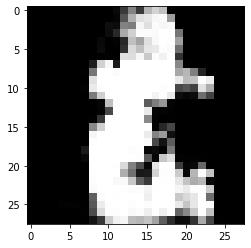

epoch  3 complete
loss: tf.Tensor(2.4239206, shape=(), dtype=float32) d_loss:  tf.Tensor(0.23739612, shape=(), dtype=float32)
condition  Dress


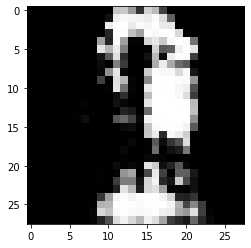

epoch  4 complete
loss: tf.Tensor(2.4800591, shape=(), dtype=float32) d_loss:  tf.Tensor(0.23257858, shape=(), dtype=float32)
condition  Dress


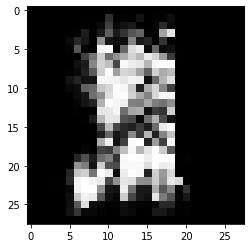

epoch  5 complete
loss: tf.Tensor(1.7186861, shape=(), dtype=float32) d_loss:  tf.Tensor(0.767648, shape=(), dtype=float32)
condition  Dress


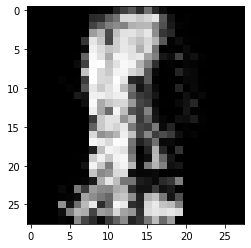

epoch  6 complete
loss: tf.Tensor(1.6145215, shape=(), dtype=float32) d_loss:  tf.Tensor(0.4591472, shape=(), dtype=float32)
condition  Dress


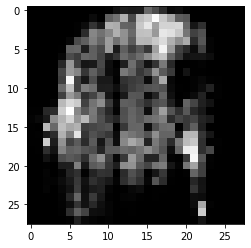

epoch  7 complete
loss: tf.Tensor(1.4744152, shape=(), dtype=float32) d_loss:  tf.Tensor(0.5983222, shape=(), dtype=float32)
condition  Dress


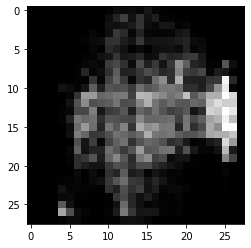

epoch  8 complete
loss: tf.Tensor(2.432999, shape=(), dtype=float32) d_loss:  tf.Tensor(0.35495853, shape=(), dtype=float32)
condition  Dress


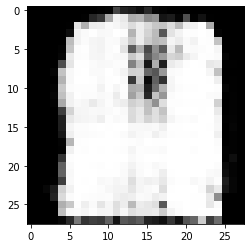

epoch  9 complete
loss: tf.Tensor(1.8301294, shape=(), dtype=float32) d_loss:  tf.Tensor(0.40811348, shape=(), dtype=float32)
condition  Dress


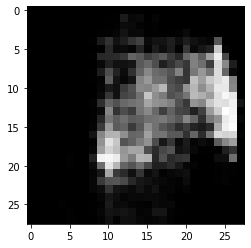

In [24]:
train()